In [1]:
import numpy as np
import pandas as pd
from random import randint
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
import os



In [2]:
from tensorflow.keras.preprocessing import image
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam

In [3]:
from google.colab import drive
import pandas as pd
import os

#Mount Google Drive
drive.mount('/content/drive')

# Automatically find your dataset zip file
zip_path = None
for root, dirs, files in os.walk('/content/drive/MyDrive'):
    for f in files:
        if f.lower().endswith('.zip') and 'dog-breed-identification' in f.lower():
            zip_path = os.path.join(root, f)
            break
    if zip_path:
        break

if zip_path is None:
    raise FileNotFoundError("Could not find 'dog-breed-identification.zip' in your Drive. Check your file name or location.")
else:
    print(f"Found dataset at: {zip_path}")

# Unzip the dataset into /content
!unzip -q "{zip_path}" -d /content/dog-breed-identification

# Check extracted files
!ls /content/dog-breed-identification

# Try to load the labels.csv (handle nested folder case)
csv_path = '/content/dog-breed-identification/labels.csv'
if not os.path.exists(csv_path):
    # sometimes it’s nested one level deeper
    nested = '/content/dog-breed-identification/dog-breed-identification/labels.csv'
    if os.path.exists(nested):
        csv_path = nested
    else:
        raise FileNotFoundError(" 'labels.csv' not found after extraction.")

# Load the CSV into pandas
df = pd.read_csv(csv_path)
print("Successfully loaded labels.csv")
df.head()

Mounted at /content/drive
Found dataset at: /content/drive/MyDrive/dog-breed-identification.zip
labels.csv  sample_submission.csv  test  train
Successfully loaded labels.csv


id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

In [4]:
print("Shape of the training data:", df.shape)
print(df.head(10))
print("\nData Information:")
print(df.info())
print("\nMissing values per column:")
print(df.isnull().sum())

Shape of the training data: (10222, 2)
                                 id               breed
0  000bec180eb18c7604dcecc8fe0dba07         boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97               dingo
2  001cdf01b096e06d78e9e5112d419397            pekinese
3  00214f311d5d2247d5dfe4fe24b2303d            bluetick
4  0021f9ceb3235effd7fcde7f7538ed62    golden_retriever
5  002211c81b498ef88e1b40b9abf84e1d  bedlington_terrier
6  00290d3e1fdd27226ba27a8ce248ce85  bedlington_terrier
7  002a283a315af96eaea0e28e7163b21b              borzoi
8  003df8b8a8b05244b1d920bb6cf451f9             basenji
9  0042188c895a2f14ef64a918ed9c7b64  scottish_deerhound

Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10222 non-null  object
 1   breed   10222 non-null  object
dtypes: object(2)
memory usage: 159.8+ KB
None

Missing values per column:

/tmp/ipython-input-3429996538.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


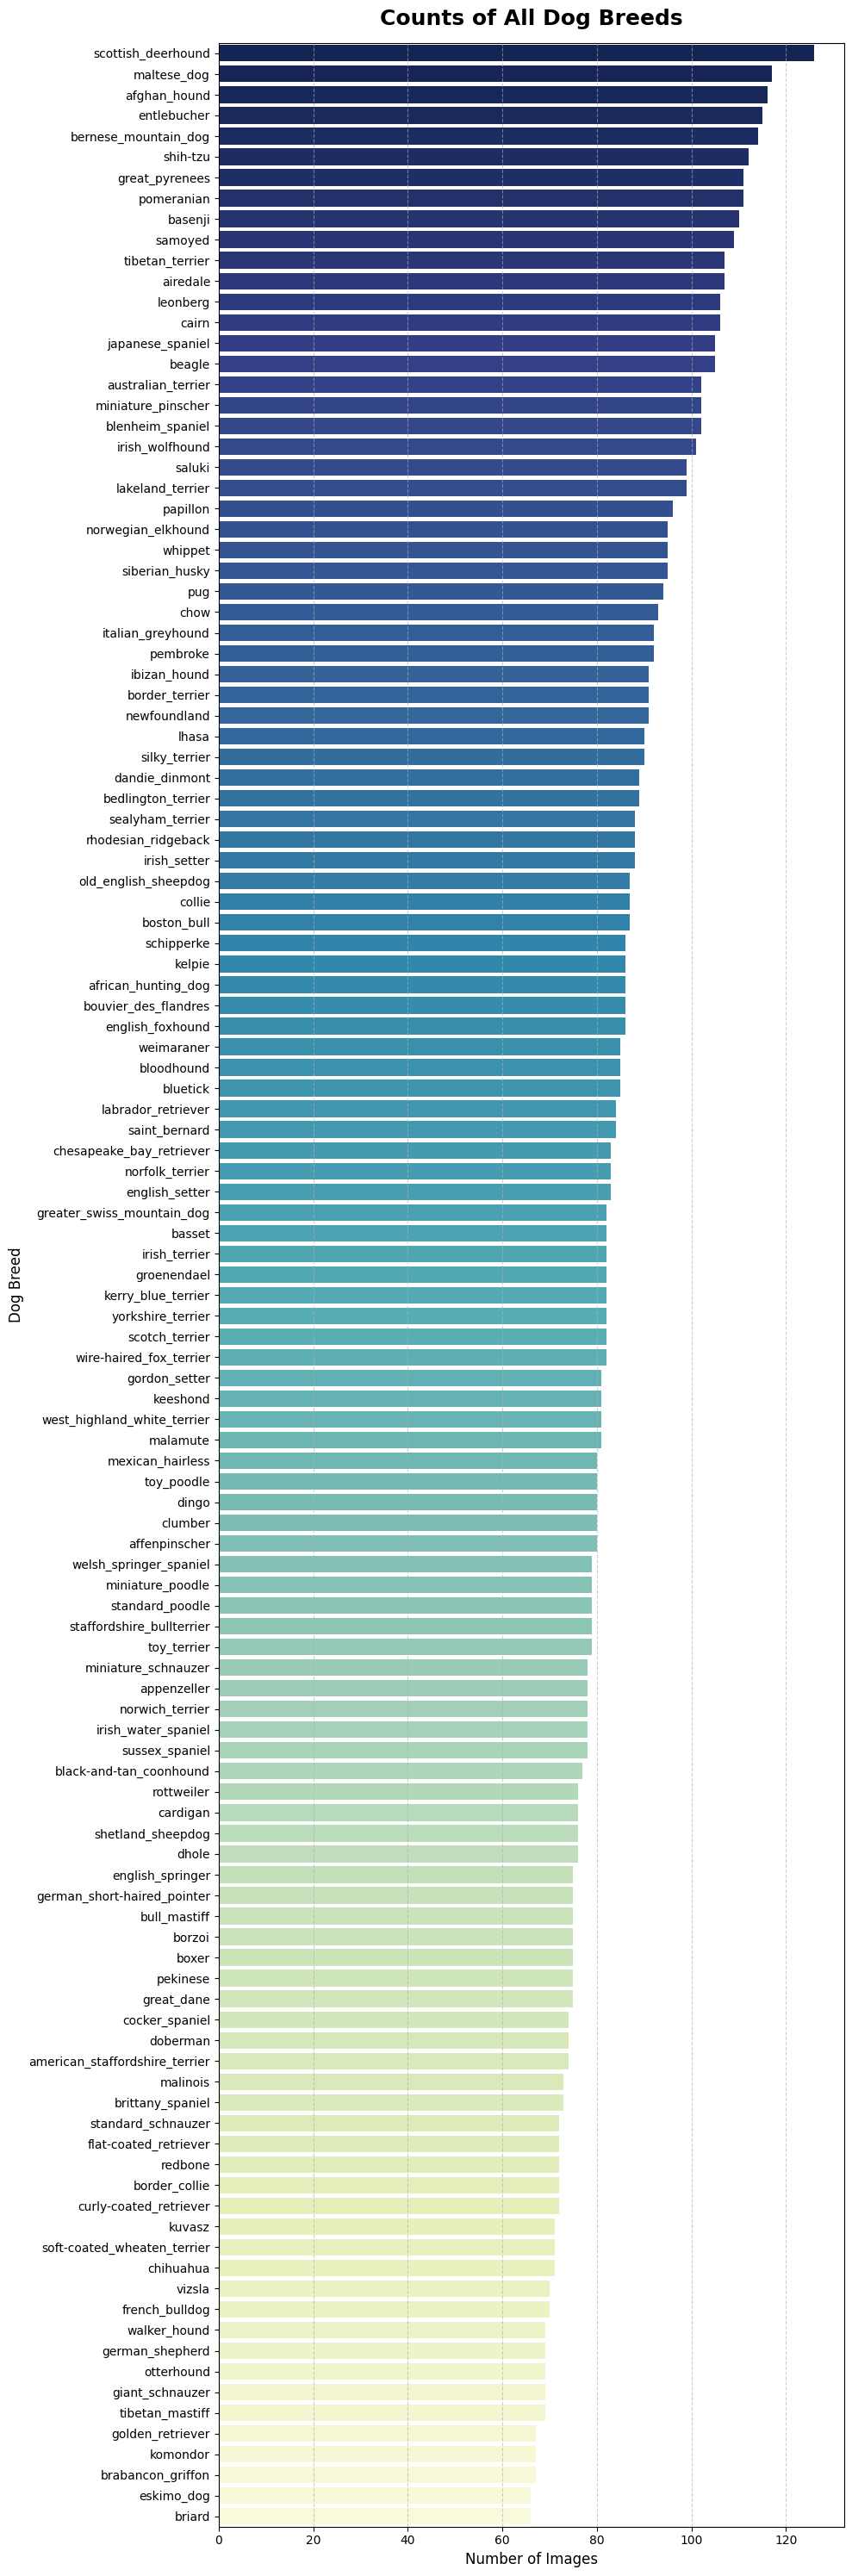

Chart saved successfully at: /content/dog_breed_countplot.png


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create and style the figure
plt.figure(figsize=(10, 30))
sns.countplot(
    y='breed',
    data=df,
    order=df['breed'].value_counts().index,
    palette="YlGnBu_r"
)
plt.title("Counts of All Dog Breeds", fontsize=18, fontweight='bold', pad=15)
plt.xlabel("Number of Images", fontsize=12)
plt.ylabel("Dog Breed", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()

# 🔹 Save the chart as a high-quality image (for your report)
save_path = "/content/dog_breed_countplot.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight')

plt.show()

print(f"Chart saved successfully at: {save_path}")

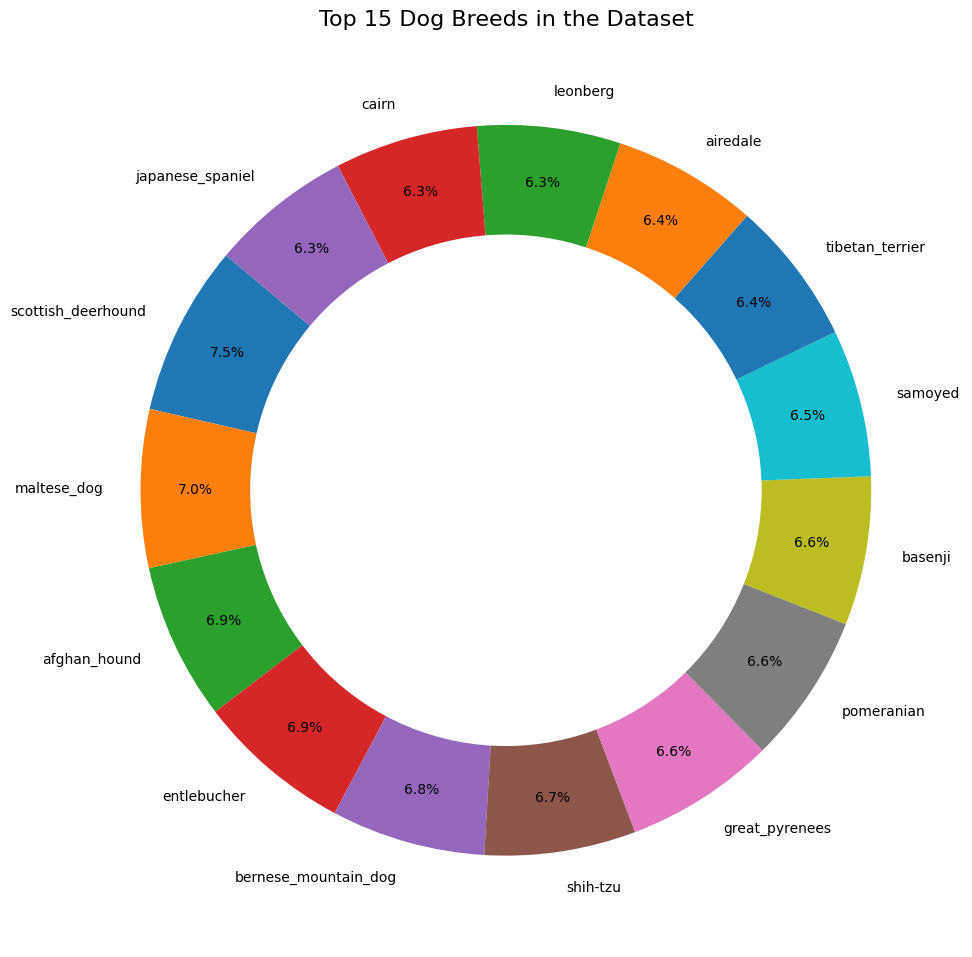

 Dog Breed Distribution:


breed
scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
shih-tzu                112
great_pyrenees          111
pomeranian              111
basenji                 110
samoyed                 109
tibetan_terrier         107
airedale                107
leonberg                106
cairn                   106
japanese_spaniel        105
Name: count, dtype: int64

In [6]:
import matplotlib.pyplot as plt

# Count how many images per breed
breed_counts = df['breed'].value_counts()

top_n = 15  # change to show more/less
breed_counts_top = breed_counts.head(top_n)

# Create the pie chart
plt.figure(figsize=(10, 10))
plt.pie(
    breed_counts_top,
    labels=breed_counts_top.index,
    autopct='%1.1f%%',
    startangle=140,
    pctdistance=0.85
)

# Data
plt.title(f"Top {top_n} Dog Breeds in the Dataset", fontsize=16)

# Make it look like a donut chart (cleaner)
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.tight_layout()
plt.show()


print(" Dog Breed Distribution:")
display(breed_counts_top)


In [ ]:
def plot_images(images, classes, img_width=224, img_height=224):

    # images (list):
    # classes (list):
    # img_width (int):
    # img_height (int):

    assert len(images) == len(classes) == 9


    fig, axes = plt.subplots(3, 3, figsize=(15, 15), sharex=True)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):

        img = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img_width, img_height))


        ax.imshow(img)

        xlabel = "Breed: {0}".format(classes[i])
        ax.set_xlabel(xlabel)
        ax.xaxis.label.set_size(10)


        ax.set_xticks([])
        ax.set_yticks([])


    plt.show()

In [ ]:
img_width = 250
img_height = 250
images = []
classes = []

# Use the path where the data was unzipped
TRAIN_DIR = '/content/dog-breed-identification/train'

for f, breed in tqdm(df.values):
    try:
        img_path = os.path.join(TRAIN_DIR, f + '.jpg')

        img = cv2.imread(img_path)

        if img is None:
            print(f"Warning: Image {img_path} could not be loaded.")
            continue

        img_resized = cv2.resize(img, (img_width, img_height))

        images.append(img_resized)
        classes.append(breed)

    except Exception as e:
        print(f"Error loading image {img_path}: {e}")
print("Number of images loaded:", len(images))
print("First 5 classes:", classes[:5])

100%|██████████| 10222/10222 [00:15<00:00, 651.11it/s]

Number of images loaded: 10222
First 5 classes: ['boston_bull', 'dingo', 'pekinese', 'bluetick', 'golden_retriever']


Random indices: [1576, 8597, 8319, 4796, 699, 4523, 8308, 936, 2286]
Images to show: 9
Classes to show: 9


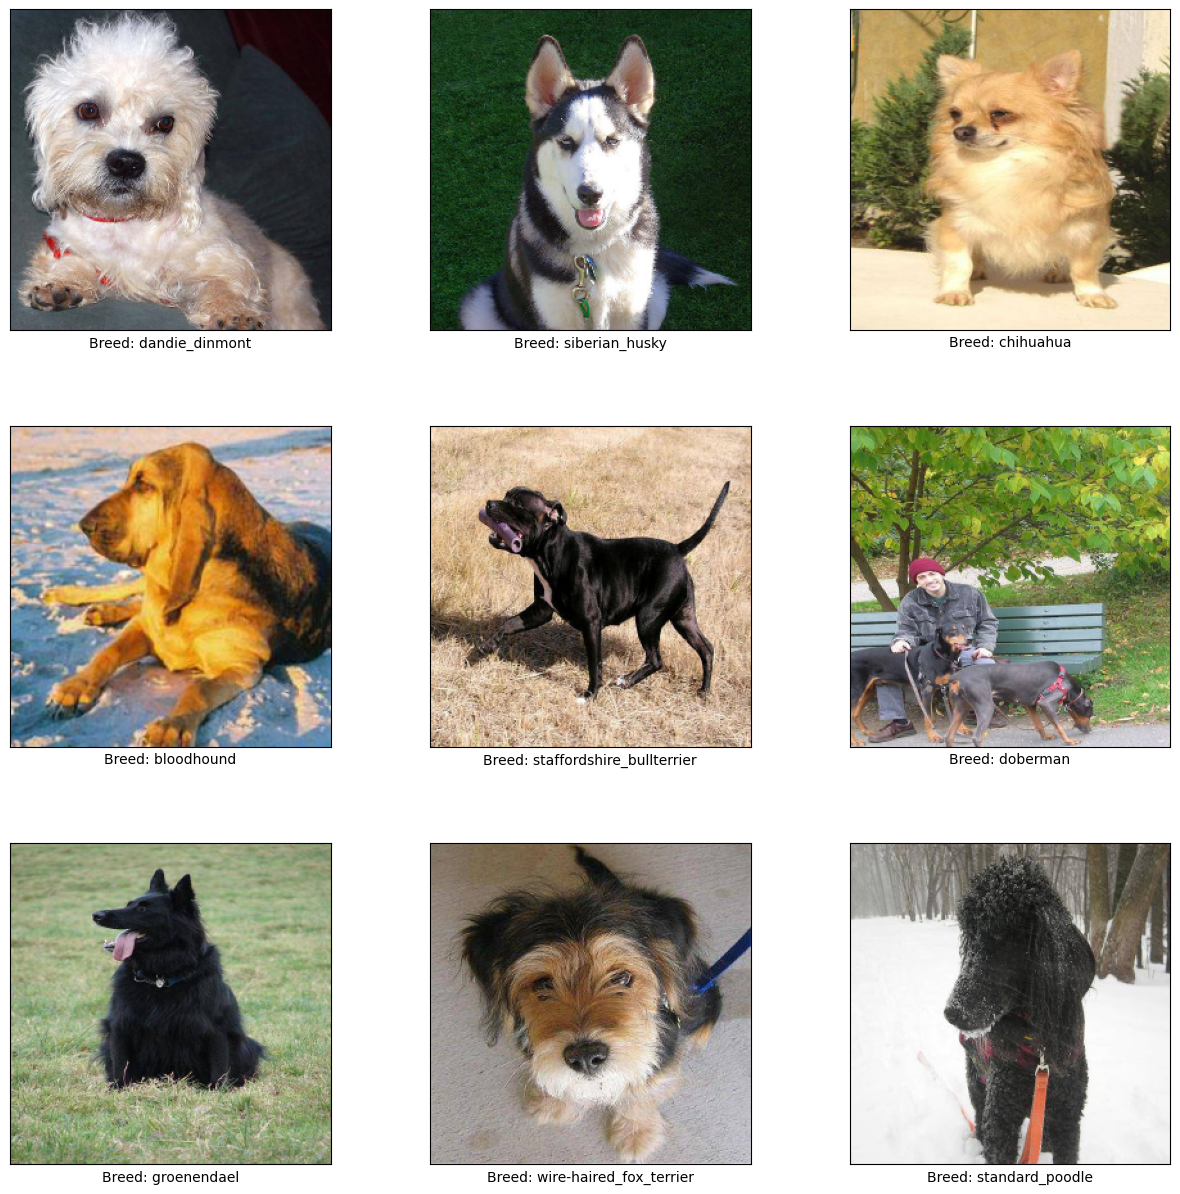

In [ ]:
num_images_to_show = 9
random_indices = [randint(0, len(images) - 1) for _ in range(num_images_to_show)]
print("Random indices:", random_indices)

images_to_show = [images[i] for i in random_indices]
classes_to_show = [classes[i] for i in random_indices]

print(f"Images to show: {len(images_to_show)}")
print(f"Classes to show: {len(classes_to_show)}")


plot_images(images_to_show, classes_to_show, img_width=img_width, img_height=img_height)

In [ ]:
selected_breeds = ['scottish_deerhound', 'maltese_dog', 'bernese_mountain_dog']


filtered_labels = df[df['breed'].isin(selected_breeds)]


filtered_labels = filtered_labels.reset_index(drop=True)


filtered_labels.head()

id                 breed
0  0042188c895a2f14ef64a918ed9c7b64    scottish_deerhound
1  00693b8bc2470375cc744a6391d397ec           maltese_dog
2  01e787576c003930f96c966f9c3e1d44    scottish_deerhound
3  022b34fd8734b39995a9f38a4f3e7b6b           maltese_dog
4  02d54f0dfb40038765e838459ae8c956  bernese_mountain_dog

In [ ]:
# Select top 20 most common breeds automatically
selected_breeds = df['breed'].value_counts().head(20).index.tolist()

print("Selected 20 breeds:")
print(selected_breeds)

# Filter dataset to only include these breeds
filtered_labels = df[df['breed'].isin(selected_breeds)].reset_index(drop=True)

print("Filtered dataset shape:", filtered_labels.shape)
filtered_labels.head()

Selected 20 breeds:
['scottish_deerhound', 'maltese_dog', 'afghan_hound', 'entlebucher', 'bernese_mountain_dog', 'shih-tzu', 'great_pyrenees', 'pomeranian', 'basenji', 'samoyed', 'tibetan_terrier', 'airedale', 'leonberg', 'cairn', 'japanese_spaniel', 'beagle', 'australian_terrier', 'miniature_pinscher', 'blenheim_spaniel', 'irish_wolfhound']
Filtered dataset shape: (2184, 2)


id               breed
0  003df8b8a8b05244b1d920bb6cf451f9             basenji
1  0042188c895a2f14ef64a918ed9c7b64  scottish_deerhound
2  00693b8bc2470375cc744a6391d397ec         maltese_dog
3  00bee065dcec471f26394855c5c2f3de               cairn
4  013f8fdf6d638c7bb042f5f17e8a9fdc     tibetan_terrier

In [ ]:
from tensorflow.keras.preprocessing import image


filtered_labels = filtered_labels.copy()


CLASS_NAMES = filtered_labels['breed'].unique()


img_height, img_width = 224, 224
X_data = np.zeros((len(filtered_labels), img_height, img_width, 3), dtype='float32')
Y_data = label_binarize(filtered_labels['breed'], classes=selected_breeds)

# Use the correct path where the data was unzipped
TRAIN_DIR = '/content/dog-breed-identification/train'

for i in tqdm(range(len(filtered_labels))):
    img_path = os.path.join(TRAIN_DIR, filtered_labels['id'][i] + '.jpg')
    img = image.load_img(img_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img)
    X_data[i] = img_array / 255.0


print('\nTrain Images shape: ', X_data.shape, ' size: {:,}'.format(X_data.size))
print('One-hot encoded output shape: ', Y_data.shape, ' size: {:,}'.format(Y_data.size))

100%|██████████| 357/357 [00:00<00:00, 594.46it/s]


Train Images shape:  (357, 224, 224, 3)  size: 53,738,496
One-hot encoded output shape:  (357, 3)  size: 1,071


In [ ]:
model = Sequential()


model.add(Conv2D(filters = 64, kernel_size = (5,5), activation ='relu', input_shape = (224,224,3)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 32, kernel_size = (3,3), activation ='relu', kernel_regularizer = 'l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 16, kernel_size = (7,7), activation ='relu', kernel_regularizer = 'l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 8, kernel_size = (5,5), activation ='relu', kernel_regularizer = 'l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(128, activation = "relu", kernel_regularizer = 'l2'))
model.add(Dense(64, activation = "relu", kernel_regularizer = 'l2'))
model.add(Dense(len(CLASS_NAMES), activation="softmax"))


model.compile(loss = 'categorical_crossentropy', optimizer = Adam(0.0001),metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 220, 220, 64)   │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 110, 110, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 108, 108, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 48, 48, 16)     │        25,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 24, 24, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 20, 20, 8)      │         3,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 10, 10, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       102,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 162,619 (635.23 KB)

 Trainable params: 162,619 (635.23 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from sklearn.model_selection import train_test_split


X_train_and_val, X_test, Y_train_and_val, Y_test = train_test_split(X_data, Y_data, test_size=0.1, random_state=42)


X_train, X_val, Y_train, Y_val = train_test_split(X_train_and_val, Y_train_and_val, test_size=0.2, random_state=42)


print('Training data shape:', X_train.shape)
print('Validation data shape:', X_val.shape)
print('Testing data shape:', X_test.shape)

Training data shape: (256, 224, 224, 3)
Validation data shape: (65, 224, 224, 3)
Testing data shape: (36, 224, 224, 3)


Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step - accuracy: 0.3438 - loss: 4.9024 - val_accuracy: 0.3692 - val_loss: 4.8787
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 381ms/step - accuracy: 0.3411 - loss: 4.8752 - val_accuracy: 0.4000 - val_loss: 4.8536
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 350ms/step - accuracy: 0.3307 - loss: 4.8498 - val_accuracy: 0.3846 - val_loss: 4.8264
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 428ms/step - accuracy: 0.3438 - loss: 4.8231 - val_accuracy: 0.3846 - val_loss: 4.7999
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 321ms/step - accuracy: 0.3776 - loss: 4.7970 - val_accuracy: 0.3692 - val_loss: 4.7737
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 344ms/step - accuracy: 0.4167 - loss: 4.7702 - val_accuracy: 0.4000 - val_loss: 4.7476
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 323ms/step - accuracy: 0.4193 - loss: 4.7454 - val_accuracy: 0.3846 - val_loss: 4.7218
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 323ms/step - accuracy: 0.4531 - loss: 4.7202 - val_accuracy: 0.4000 - val_

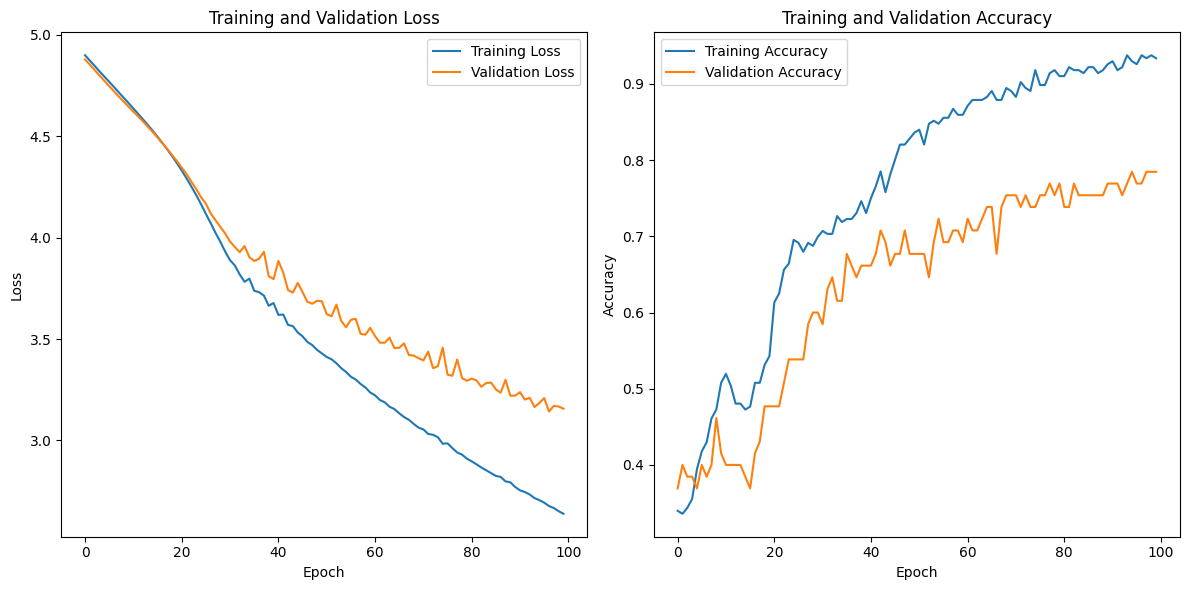

In [ ]:
history = model.fit(X_train, Y_train, batch_size=128, epochs=100, validation_data=(X_val, Y_val))


plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
Y_pred = model.predict(X_test)
loss, accuracy = model.evaluate(X_test, Y_test)
print(f'Accuracy over the test set: {accuracy * 100:.2f}%')

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 821ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step - accuracy: 0.7894 - loss: 3.0412
Accuracy over the test set: 77.78%


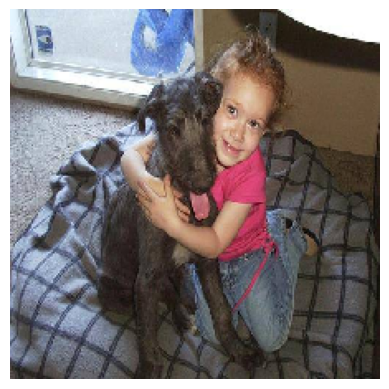

Originally: scottish_deerhound
Predicted: scottish_deerhound


In [ ]:
plt.imshow(X_test[2])
plt.axis('off')
plt.show()

true_label = filtered_labels['breed'][np.argmax(Y_test[2])]
predicted_label = filtered_labels['breed'][np.argmax(Y_pred[2])]

print("Originally:", true_label)
print("Predicted:", predicted_label)

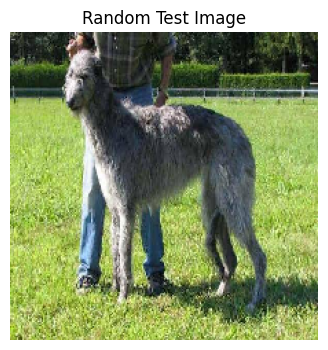

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
🔹 True Breed: bernese_mountain_dog
🔸 Predicted Breed: bernese_mountain_dog
🤖 Model Confidence: 84.92%

Top 3 Predictions:
  bernese_mountain_dog: 84.92%
  scottish_deerhound: 14.99%
  maltese_dog: 0.09%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import LabelEncoder

# ---------------------------------------------------------
# Fit a LabelEncoder to the selected breed names
# ---------------------------------------------------------
le = LabelEncoder()
le.fit(selected_breeds)


# ---------------------------------------------------------
# 1. Pick a random image index from the test set
# ---------------------------------------------------------
random_index = random.randint(0, len(X_test) - 2)

# Extract the random image and its true label
image = X_test[random_index]
true_label_index = np.argmax(Y_test[random_index])

# Display the image
plt.figure(figsize=(4, 4))
plt.imshow(image)
plt.axis('off')
plt.title("Random Test Image")
plt.show()

# ---------------------------------------------------------
# 2. Prepare the image for prediction
# ---------------------------------------------------------
# Model expects a batch, so expand dimensions: (1, 250, 250, 3)
image_batch = np.expand_dims(image, axis=0)

# ---------------------------------------------------------
# 3. Predict the class
# ---------------------------------------------------------
prediction = model.predict(image_batch)
predicted_index = np.argmax(prediction)

# ---------------------------------------------------------
# 4. Decode labels (convert from numeric to breed names)
# ---------------------------------------------------------
true_label = le.inverse_transform([true_label_index])[0]
predicted_label = le.inverse_transform([predicted_index])[0]

# ---------------------------------------------------------
# 5. Print results
# ---------------------------------------------------------
print(f"🔹 True Breed: {true_label}")
print(f"🔸 Predicted Breed: {predicted_label}")
print(f"🤖 Model Confidence: {np.max(prediction) * 100:.2f}%")

# Optional: show prediction probabilities for top 3 breeds
top3_indices = prediction[0].argsort()[-3:][::-1]
top3_labels = le.inverse_transform(top3_indices)
top3_conf = prediction[0][top3_indices] * 100

print("\nTop 3 Predictions:")
for lbl, conf in zip(top3_labels, top3_conf):
    print(f"  {lbl}: {conf:.2f}%")

🖼️ Selected image: /content/dog-breed-identification/test/ba1b8af294800b762f04ebdfbe3bab7a.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


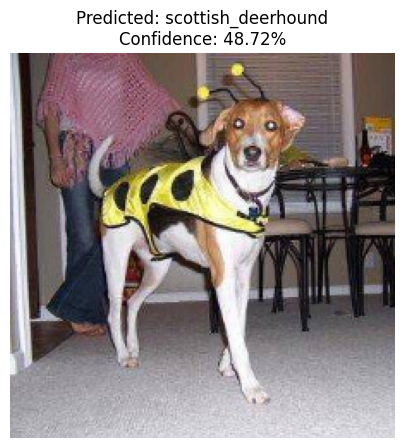

🔸 Predicted Breed: scottish_deerhound
🤖 Model Confidence: 48.72%


In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.preprocessing import image

# ---------------------------------------------------------
# 1. Define your test directory
# ---------------------------------------------------------
# Example path — change this to your actual test folder
TEST_DIR = '/content/dog-breed-identification/test'

# ---------------------------------------------------------
# 2. Pick a random image file from the test directory
# ---------------------------------------------------------
all_test_images = os.listdir(TEST_DIR)
random_image = random.choice(all_test_images)
image_path = os.path.join(TEST_DIR, random_image)

print("🖼️ Selected image:", image_path)

# ---------------------------------------------------------
# 3. Load and preprocess the image
# ---------------------------------------------------------
img_width, img_height = 224, 224  # Change to match training size

# Read image using OpenCV
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_resized = cv2.resize(img, (img_width, img_height))

# Normalize pixel values (same as training)
img_array = img_resized / 255.0
img_array = np.expand_dims(img_array, axis=0)  # add batch dimension

# ---------------------------------------------------------
# 4. Predict the breed
# ---------------------------------------------------------
prediction = model.predict(img_array)
predicted_index = np.argmax(prediction)
predicted_label = le.inverse_transform([predicted_index])[0]
confidence = np.max(prediction) * 100

# ---------------------------------------------------------
# 5. Display image and results
# ---------------------------------------------------------
plt.figure(figsize=(5,5))
plt.imshow(img_resized)
plt.axis('off')
plt.title(f"Predicted: {predicted_label}\nConfidence: {confidence:.2f}%")
plt.show()

print(f"🔸 Predicted Breed: {predicted_label}")
print(f"🤖 Model Confidence: {confidence:.2f}%")

Saving 00102ee9d8eb90812350685311fe5890.jpg to 00102ee9d8eb90812350685311fe5890 (1).jpg
🖼️ Uploaded image: 00102ee9d8eb90812350685311fe5890 (1).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


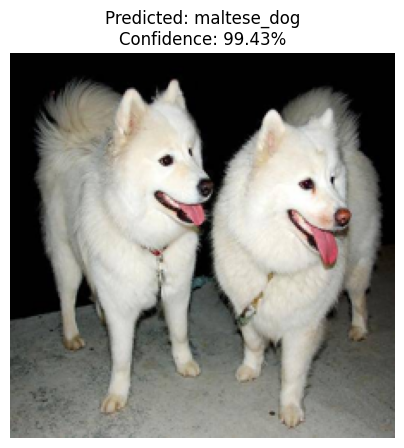

🔸 Predicted Breed: maltese_dog
🤖 Model Confidence: 99.43%


In [ ]:
from google.colab import files
import matplotlib.pyplot as plt
import numpy as np
import cv2
from tensorflow.keras.preprocessing import image
from PIL import Image

# ---------------------------------------------------------
# 1. Upload any image
# ---------------------------------------------------------
uploaded = files.upload()

# Get uploaded filename
for filename in uploaded.keys():
    img_path = filename

print(f"🖼️ Uploaded image: {img_path}")

# ---------------------------------------------------------
# 2. Load and preprocess the image
# ---------------------------------------------------------
img_width, img_height = 224, 224  # same as during training

# Open image and convert to RGB
img = Image.open(img_path).convert('RGB')
img = img.resize((img_width, img_height))

# Convert to numpy array and normalize
img_array = np.array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# ---------------------------------------------------------
# 3. Predict breed
# ---------------------------------------------------------
prediction = model.predict(img_array)
predicted_index = np.argmax(prediction)
predicted_label = le.inverse_transform([predicted_index])[0]
confidence = np.max(prediction) * 100

# ---------------------------------------------------------
# 4. Display image and result
# ---------------------------------------------------------
plt.figure(figsize=(5,5))
plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted: {predicted_label}\nConfidence: {confidence:.2f}%")
plt.show()

print(f"🔸 Predicted Breed: {predicted_label}")
print(f"🤖 Model Confidence: {confidence:.2f}%")